# Universidad Politécnica Salesiana



![Universidad Politécnica Salesiana](https://github.com/vlarobbyk/fundamentos-vision-artificial-doctoradoCC/blob/main/images/Logo-UPS-30-Años.png?raw=true)

# $${\color{blue}{\small{ Visión ~por~ Computador \\ Carrera ~de~ Computación}}}$$


# Operador de Canny: tutorial didáctico basado en Tensores y PyTorch

**autor:** _vlarobbyk_

**Nivel:** Experto / Académico

**Enfoque:** Fundamento Matemático (LaTeX) + Implementación (PyTorch)

En este tutorial se explica cómo aplicar el algoritmo Canny considerando una explicación matemática de cada paso a partir de una matriz de $5 \times 5$ diseñada para probar la robustez ante el ruido y el contraste diagonal.

-----

## 1\. Definición del Espacio de Entrada (Matriz $I$)

Definimos una imagen $I$ de $5 \times 5$ con un **borde diagonal** ruidoso.

  * **Región Oscura ($R_1$):** Valores aleatorios $\in [20, 33]$.
  * **Región Clara ($R_2$):** Valores aleatorios $\in [213, 253]$.

<br />
$$
I = \begin{pmatrix}
25 & 30 & 28 & 33 & 218 \\
31 & 22 & 32 & 225 & 230 \\
29 & 26 & \mathbf{240} & 245 & 250 \\
33 & 235 & 240 & 253 & 248 \\
215 & 230 & 240 & 250 & 245
\end{pmatrix}
$$
<br />
El cálculo de ejemplo se realizará para el píxel $I(2,2) = 240$ (usando indexación basada en 0, es decir, la primera fila ocupa el índice cero al igual que la primera columna. Con ello, el pixel a considerar está en la fila 2, y columna 2).

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as pp

Shape de la imagen en Numpy: (5, 5)


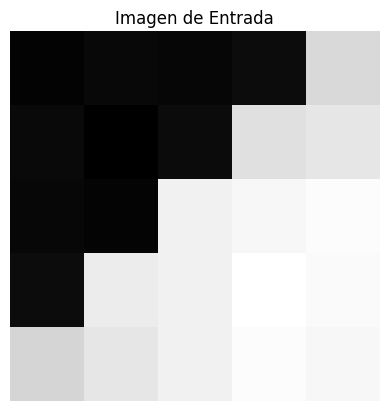

In [2]:
# Definición del Tensor
data = [
  [25., 30., 28., 33., 218.],
  [31., 22., 32., 225., 230.],
  [29., 26., 240., 245., 250.],
  [33., 235., 240., 253., 248.],
  [215., 230., 240., 250., 245.]
]
I = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Convertimos el tensor en una matriz de NumPy para poder visualizarlo en pantalla
I_np = I.squeeze()
I_np = I_np.numpy()

# Verificamos las dimensiones de nuestro tensor
print(f'Shape de la imagen en Numpy: {I_np.shape}')

# Visualizamos el tensor usando la librería MatPlotLib
figure, axes = pp.subplots(nrows = 1, ncols = 1)
axes.imshow(I_np, cmap='gray')
axes.set_title('Imagen de Entrada')
axes.axis('off')

pp.show()


## Etapa 1: Suavizado Gaussiano

El ruido en $R_1$ (varianza entre 22 y 31) produciría falsos bordes. Aplicamos convolución con un kernel Gaussiano $G$ de $3 \times 3$ ($\sigma \approx 1$).

### Cálculo Matemático

**Kernel Gaussiano $G$:**

$$G = \frac{1}{16}
\begin{pmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{pmatrix}
$$
<br />

**Operación de Convolución en $I(2,2)$:**
Tomamos la vecindad de $3 \times 3$ centrada en $(2,2)$:

$$
\text{Vecindad} =
\begin{pmatrix}
22 & 32 & 225 \\
26 & 240 & 245 \\
235 & 240 & 253
\end{pmatrix}
$$
<br />

Aplicamos la suma ponderada (producto Hadamard y suma):

$$S(2,2) = \frac{1}{16}  
\left[ (22 \cdot1) + (32 \cdot2) + (225 \cdot1) + (26 \cdot2) + (240 \cdot4) + (245 \cdot2) + (235 \cdot1) + (240 \cdot2) + (253 \cdot1)  \right]
$$
<br />

$$
S(2,2) = \frac{1}{16} \left[ 22 + 64 + 225 + 52 + 960 + 490 + 235 + 480 + 253 \right]
$$
<br />


$$
S(2,2) = \frac{2781}{16} \approx \mathbf{173.81}
$$
<br />

*Interpretación:* El valor bajó de 240 a 173.81 porque los vecinos oscuros (22, 26, 32) "llevaron" el promedio hacia abajo, suavizando la transición.

### 💻 Código PyTorch

Valor Suavizado S(2,2): 173.81
Shape de la imagen suavizada en Numpy: (5, 5)


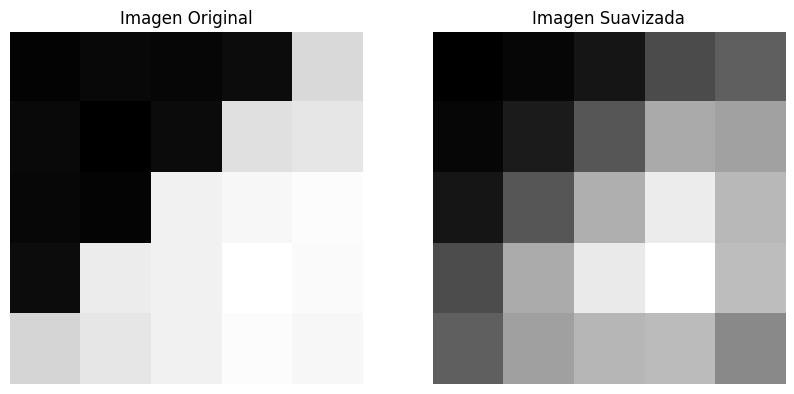

In [ ]:
# Kernel Gaussiano
K_g = torch.tensor([[1., 2., 1.], [2., 4., 2.], [1., 2., 1.]]) / 16.0
K_g = K_g.view(1, 1, 3, 3)

# Convolución
S = F.conv2d(I, K_g, padding=1)
print(f"Valor Suavizado S(2,2): {S[0,0,2,2].item():.2f}")

S_np = S.squeeze()
S_np = S_np.numpy()

# Verificamos las dimensiones de nuestro tensor
print(f'Shape de la imagen suavizada en Numpy: {S_np.shape}')

# Visualizamos el tensor usando la librería MatPlotLib
figure, axes = pp.subplots(nrows = 1, ncols = 2)
figure.set_size_inches(10, 7)
axes[0].imshow(I_np, cmap='gray')
axes[0].set_title('Imagen Original')
axes[0].axis('off')

axes[1].imshow(S_np, cmap='gray')
axes[1].set_title('Imagen Suavizada')
axes[1].axis('off')

pp.show()

-----

## Etapa 2: Gradientes (Sobel)

Calculamos la magnitud y dirección del cambio de intensidad usando la imagen suavizada $S$.

### Cálculo Matemático

**Kernels Sobel:**

$$
K_x = \begin{pmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{pmatrix}, \quad
K_y = \begin{pmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{pmatrix}
$$

<br />
**Cálculo en** $\mathbf{(2,2)}$:
<br />

_Nota: Para este ejemplo manual, aproximaremos usando los valores crudos de la vecindad para demostrar la magnitud del contraste, aunque el código usa $S$._

<br />

**Gradiente Horizontal** ($\mathbf{G_{x}}$): (Diferencia columna derecha - izquierda)

$$
G_{x} \approx (225 \cdot1 + 245 \cdot2 + 253 \cdot1) - (22 \cdot1 + 26 \cdot2 + 235 \cdot1)
$$

<br />
$$
G_{x} \approx (225 + 490 + 253) - (22 + 52 + 235) = 968 - 309 =  \mathbf{659}
$$
<br />

**Gradiente Vertical** ($\mathbf{G_{y}}$): (Diferencia fila inferior - superior)

$$
G_{y} \approx (235\cdot1 + 240\cdot2 + 253\cdot1) - (22\cdot1 + 32\cdot2 + 225\cdot1)
$$
<br />
$$
G_{y} \approx (235 + 480 + 253) - (22 + 64 + 225) = 968 - 311 = \mathbf{657}
$$
<br />
**Magnitud ($M$) y Ángulo ($\theta$):**

$$M(2,2) = \sqrt{G_{x}^2 + G_{y}^2} = \sqrt{659^2 + 657^2} \approx \sqrt{434281 + 431649} \approx \mathbf{930.5}
$$
<br />
$$
\theta(2,2) = \arctan \left( \frac{G_{y}}{G_{x}} \right) = \arctan \left( \frac{657}{659} \right) \approx \arctan(0.996) \approx \mathbf{44.9^ \circ}
$$
<br />
*Interpretación:* La magnitud es muy alta (borde fuerte) y el ángulo es casi $45^\circ$, lo que confirma un borde diagonal perfecto.

### Código PyTorch

Magnitud M(2,2): 674.76
Ángulo Theta(2,2): 44.90°
M: 
 tensor([[[[116.0539, 224.1939, 471.4281, 627.8052, 596.8276],
          [224.4644, 429.2139, 675.2609, 554.4283, 721.3079],
          [472.6906, 673.7760, 674.7576, 317.4027, 884.2573],
          [627.4022, 547.3550, 316.3659, 169.6550, 917.8605],
          [596.9218, 718.9081, 882.0811, 916.9064, 875.0463]]]])


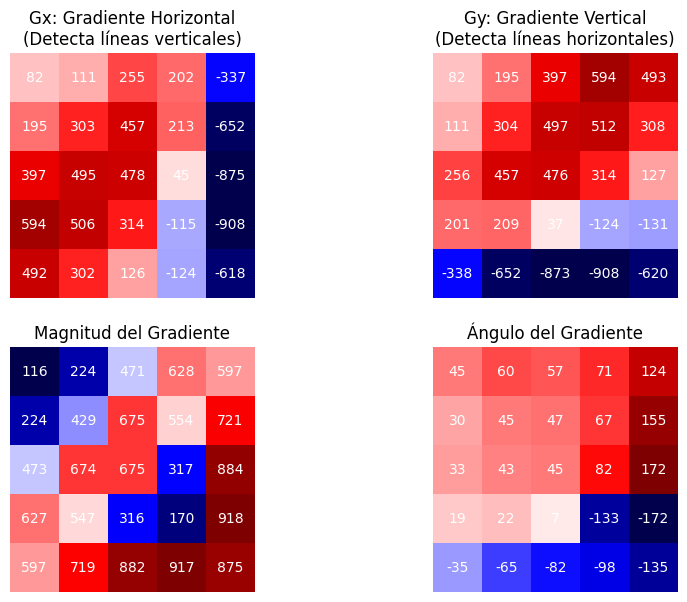

In [ ]:
K_x = torch.tensor([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]]).view(1,1,3,3)
K_y = torch.tensor([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]]).view(1,1,3,3)

Gx = F.conv2d(S, K_x, padding=1)
Gy = F.conv2d(S, K_y, padding=1)

M = torch.sqrt(Gx**2 + Gy**2)
Theta = torch.atan2(Gy, Gx) * (180 / np.pi)
Theta_raw = Theta.clone()
Theta[Theta < 0] += 180 # Normalizar [0, 180]

print(f"Magnitud M(2,2): {M[0,0,2,2].item():.2f}")
print(f"Ángulo Theta(2,2): {Theta[0,0,2,2].item():.2f}°")

#print('Gx:', '\n', Gx)
print('M:', '\n', M)


maxim = abs(torch.max(Gx))+100

figure, axes = pp.subplots(nrows = 2, ncols = 2)
figure.set_size_inches(10, 7)

axes[0, 0].imshow(Gx.squeeze().numpy(), cmap='seismic', vmin=-maxim, vmax=maxim)
axes[0, 0].set_title('Gx: Gradiente Horizontal\n(Detecta líneas verticales)')
axes[0, 0].axis('off')

axes[0, 1].imshow(Gy.squeeze().numpy(), cmap='seismic', vmin=-maxim, vmax=maxim)
axes[0, 1].set_title('Gy: Gradiente Vertical\n(Detecta líneas horizontales)')
axes[0, 1].axis('off')

axes[1, 0].imshow(M.squeeze().numpy(), cmap='seismic', vmin=torch.min(M), vmax=torch.max(M))
axes[1, 0].set_title('Magnitud del Gradiente')
axes[1, 0].axis('off')


axes[1, 1].imshow(Theta_raw.squeeze().numpy(), cmap='seismic', vmin=torch.min(Theta_raw), vmax=torch.max(Theta_raw))
axes[1, 1].set_title('Ángulo del Gradiente')
axes[1, 1].axis('off')


color = None
row = 0
col = 0
for matrix in [Gx.squeeze().numpy(), Gy.squeeze().numpy(), M.squeeze().numpy(), Theta_raw.squeeze().numpy()]:
  for (j,i), label in np.ndenumerate(matrix):
    color = 'white' if abs(label) > 400 else 'black'
    axes[row, col].annotate(f"{label:.0f}", (i, j), ha='center', va='center', color='w')
  col+=1
  if (col>1):
    col = 0
    row += 1


pp.show()

-----

## Etapa 3: Supresión de No Máximos (NMS)


Para calcular la **Etapa NMS (Supresión de No Máximos)** en el píxel $(2,2)$, necesitamos comparar su magnitud con la de sus vecinos en la dirección del gradiente.

**Datos de partida (Tensor** $\mathbf{M}$ **):**
$$
\begin{pmatrix}
... & ... & ... & ... & ... \\
... & 429.2 & \mathbf{675.3} & \mathbf{554.4} & ... \\
... & \mathbf{673.8} & \color{red}{\mathbf{674.8}} & 317.4 & ... \\
... & \mathbf{547.4} & 316.4 & 169.7 & ... \\
... & ... & ... & ... & ...
\end{pmatrix}
$$
*(Se ha simplificado los decimales para visualizarlo mejor)*.

* **Centro $(2,2)$:** $M(2,2) = \mathbf{674.7576}$

#### 1. El Ángulo
Mantenemos que la dirección del borde es diagonal ($\approx 45^\circ$), ya que la estructura de la imagen no ha cambiado.
* Dirección: **45° (Diagonal Positiva)**.
* Vecinos a comparar: **Arriba-Derecha** $(1,3)$ y **Abajo-Izquierda** $(3,1)$.

#### 2. Identificando a los Vecinos en el Tensor
Analizando la matriz:
* **Vecino Arriba-Derecha $(1,3)$:** Fila 1, Columna 3 $\rightarrow$ Valor = **554.4283**
* **Vecino Abajo-Izquierda $(3,1)$:** Fila 3, Columna 1 $\rightarrow$ Valor = **547.3550**

*(Nota: Recordar que las filas son el primer índice [0,1,2,3,4] y columnas el segundo)*.

#### 3. La Comparación (NMS)
Ahora aplicamos la lógica: ¿Es el centro el valor máximo en esa dirección?

$$
NMS(2,2) =
\begin{cases}
674.76 & \text{si } \mathbf{674.76} \ge 554.43 \land \mathbf{674.76} \ge 547.36 \\
0 & \text{en otro caso}
\end{cases}
$$

* **Comparación 1:** $674.76 > 554.43$ (VERDADERO)
* **Comparación 2:** $674.76 > 547.36$ (VERDADERO)

#### Conclusión
El píxel $(2,2)$ **SOBREVIVE** y se mantiene como borde.

Si nos fijamos en tu tensor, el valor $675.2609$ en la posición $(1,2)$ es mayor que nuestro centro, pero como la dirección del gradiente en $(2,2)$ nos manda a comparar con la diagonal, no competimos con el píxel de arriba $(1,2)$, sino con los de la diagonal. **Por eso el algoritmo de Canny es tan preciso: solo compara en la dirección del flujo del gradiente.**


### Análisis Lógico y Matemático (El caso 23.37°)

Supongamos que, debido al ruido, en un píxel vecino el cálculo de $\theta$ hubiera dado **23.37°**.

**1. Cuantización del Ángulo:**
Debemos asignar 23.37° a uno de los 4 sectores principales ($0^\circ, 45^\circ, 90^\circ, 135^\circ$).
La función de cuantización $Q(\theta)$ se define como:

$$
Q(\theta) =
\begin{cases}
0^\circ & \text{si } \theta \in [0, 22.5) \cup [157.5, 180] \\
45^\circ & \text{si } \theta \in [22.5, 67.5) \\
90^\circ & \text{si } \theta \in [67.5, 112.5) \\
135^\circ & \text{si } \theta \in [112.5, 157.5)
\end{cases}
$$Para $\theta = 23.37^\circ$:

$$
22.5 < 23.37 < 67.5 \implies Q(23.37^\circ) = \mathbf{45^\circ} \text{ (Diagonal)}
$$

**2. Comparación de Vecinos:**
Si estamos en $(i, j)$ con dirección $45^\circ$, la derivada es máxima perpendicular al borde. Debemos comparar la magnitud $M(i,j)$ con los vecinos en la dirección del gradiente (la diagonal positiva):

  * Vecino $p$: $(i-1, j+1)$ (Arriba-Derecha)
  * Vecino $r$: $(i+1, j-1)$ (Abajo-Izquierda)

**3. Ecuación de Supresión:**

$$
NMS(i,j) =
\begin{cases}
M(i,j) & \text{si } M(i,j) \ge M(i-1, j+1) \land M(i,j) \ge M(i+1, j-1) \\
0 & \text{en otro caso}
\end{cases}
$$Si $M(i,j)$ es el pico de la montaña, se queda. Si no, se apaga.

### Código PyTorch (NMS Simplificado)

In [ ]:
def nms_step(mag, ang):
    """
    Aplica Supresión de No Máximos.
    mag: Tensor de magnitud (Batch, Channel, Height, Width)
    ang: Tensor de ángulo (Batch, Channel, Height, Width)
    """
    B, C, H, W = mag.shape
    res = torch.zeros_like(mag)

    # Quitamos dimensiones de batch/channel para iterar más fácil (suponiendo B=1, C=1)
    m = mag.squeeze()
    a = ang.squeeze()

    # Iteramos sobre los píxeles (excluyendo el borde de 1px para evitar errores de índice)
    for i in range(1, H-1):
        for j in range(1, W-1):
            q = 255.0
            r = 255.0
            angle = a[i,j].item()

            # --- Lógica de Ángulos ---
            # Ángulo 0 (Horizontal)
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                q = m[i, j+1]
                r = m[i, j-1]

            # Ángulo 45 (Diagonal /)
            elif (22.5 <= angle < 67.5):
                q = m[i-1, j+1] # Arriba-Derecha
                r = m[i+1, j-1] # Abajo-Izquierda

            # Ángulo 90 (Vertical)
            elif (67.5 <= angle < 112.5):
                q = m[i+1, j]   # Abajo
                r = m[i-1, j]   # Arriba

            # Ángulo 135 (Diagonal \)
            elif (112.5 <= angle < 157.5):
                q = m[i-1, j-1] # Arriba-Izquierda
                r = m[i+1, j+1] # Abajo-Derecha

            # --- Comparación y Supresión ---
            if (m[i,j] >= q) and (m[i,j] >= r):
                res[0,0,i,j] = m[i,j] # Se mantiene el valor
            else:
                res[0,0,i,j] = 0      # Se suprime

    return res

-----

## Etapa 4: Histéresis

Clasificación final de bordes basada en umbrales.

### Lógica Matemática

Definimos dos umbrales: $T_{high}$ y $T_{low}$.
Sea $E(i,j)$ el píxel final de borde.

$$E(i,j) =
\begin{cases}
1 (\text{Fuerte}) & \text{si } NMS(i,j) \ge T_{high} \\
1 (\text{Débil Conectado}) & \text{si } T_{low} \le NMS(i,j) < T_{high} \land \exists (x,y) \in N_{8}(i,j) \text{ tal que } E(x,y)=1 \\
0 (\text{Ruido}) & \text{en otro caso}
\end{cases}
$$
<br />
Para nuestro ejemplo manual, si $M(2,2) \approx 674.75$:

  * Si definimos $T_{high} = 200$, entonces $674.75 \ge 200$.
  * $\therefore E(2,2) = \mathbf{1}$ (Es un borde fuerte definitivo).

-----




### Resumen del Contenido Matemático

#### 1\. Suavizado Gaussiano

Para eliminar el ruido que introdujimos (valores aleatorios en $R_1$), aplicamos la convolución discreta:

$$S(x,y) = I(x,y) * G(x,y) = \sum_{i=-1}^{1} \sum_{j=-1}^{1} I(x-i, y-j) \cdot G(i,j)$$

En nuestro ejemplo manual para el píxel central $I(2,2)=240$:
$$S(2,2) = \frac{2781}{16} \approx 173.81$$

#### 2\. Gradientes (Sobel)

La magnitud del gradiente $M$ en el punto $(x,y)$ se calcula mediante la norma euclidiana de los vectores derivados parciales aproximados:

$$M(x,y) = \sqrt{G_x(x,y)^2 + G_y(x,y)^2}$$

Donde $G_x$ y $G_y$ son las respuestas a los filtros de Sobel horizontal y vertical.
Para nuestro píxel central:
$$M(2,2) \approx \sqrt{659^2 + 657^2} \approx 930.5$$

#### 3\. Supresión de No Máximos (Lógica Matemática)

Formalizamos la decisión de mantener o suprimir un píxel basándonos en su ángulo cuantizado $Q(\theta)$. Para el caso específico de **23.37°**:

$$Q(23.37^\circ) = 45^\circ \implies \text{Comparar con } M_{i-1, j+1} \text{ y } M_{i+1, j-1}$$

La función de activación del borde delgado es:
$$NMS(i,j) = M(i,j) \cdot \mathbb{1}(M(i,j) \ge M_{neighbors})$$
*(Donde $\mathbb{1}$ es la función indicatriz)*.

-----

## Ejercicio Extendido: Imagen 7×7 con Análisis de los 8 Vecinos

En este ejercicio extendido, trabajaremos con una matriz de $7 \times 7$ y analizaremos el píxel central $(3,3)$ junto con sus **8 vecinos** en todas las etapas del algoritmo de Canny.

Shape de la imagen 7x7: (7, 7)

Matriz de la imagen 7x7:
[[ 20.  25.  22.  28.  30. 215. 220.]
 [ 24.  21.  26.  29. 218. 225. 230.]
 [ 27.  23.  30. 210. 228. 235. 240.]
 [ 29.  25. 215. 240. 245. 250. 248.]
 [ 26. 220. 230. 245. 250. 253. 245.]
 [225. 235. 240. 248. 255. 250. 243.]
 [230. 238. 242. 250. 252. 246. 240.]]


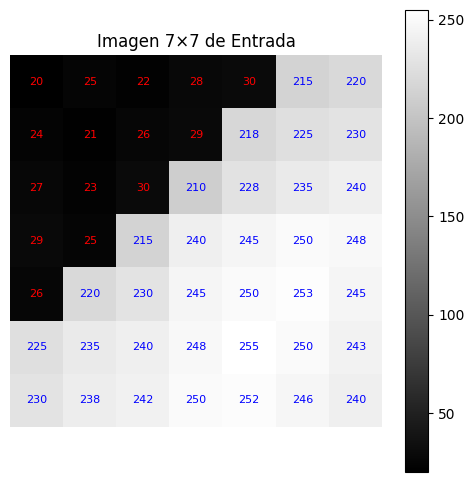

In [3]:
# Definición de la imagen 7x7
data_7x7 = [
    [20., 25., 22., 28., 30., 215., 220.],
    [24., 21., 26., 29., 218., 225., 230.],
    [27., 23., 30., 210., 228., 235., 240.],
    [29., 25., 215., 240., 245., 250., 248.],
    [26., 220., 230., 245., 250., 253., 245.],
    [225., 235., 240., 248., 255., 250., 243.],
    [230., 238., 242., 250., 252., 246., 240.]
]

I_7x7 = torch.tensor(data_7x7, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
I_7x7_np = I_7x7.squeeze().numpy()

print(f'Shape de la imagen 7x7: {I_7x7_np.shape}')
print(f'\nMatriz de la imagen 7x7:')
print(I_7x7_np)

# Visualización
figure, axes = pp.subplots(nrows=1, ncols=1, figsize=(6, 6))
im = axes.imshow(I_7x7_np, cmap='gray')
axes.set_title('Imagen 7×7 de Entrada')
axes.axis('off')

# Anotaciones con valores
for (j, i), label in np.ndenumerate(I_7x7_np):
    axes.text(i, j, f'{int(label)}', ha='center', va='center', 
              color='red' if label < 100 else 'blue', fontsize=8)

pp.colorbar(im, ax=axes)
pp.show()

In [5]:
# Definir el kernel Gaussiano (necesario para el ejercicio 7x7)
K_g = torch.tensor([[1., 2., 1.], [2., 4., 2.], [1., 2., 1.]]) / 16.0
K_g = K_g.view(1, 1, 3, 3)

# Definir los kernels de Sobel (necesarios para gradientes)
K_x = torch.tensor([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]]).view(1,1,3,3)
K_y = torch.tensor([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]]).view(1,1,3,3)

print("✓ Kernels Gaussiano y Sobel definidos correctamente")

✓ Kernels Gaussiano y Sobel definidos correctamente


### Etapa 1: Suavizado Gaussiano (7×7)

Aplicamos el kernel Gaussiano de $3 \times 3$ sobre la imagen de $7 \times 7$:

**Para el píxel central $(3,3)$ con valor $240$:**

Vecindad de $3 \times 3$:
$$
\text{Vecindad}_{(3,3)} =
\begin{pmatrix}
30 & 210 & 228 \\
25 & 240 & 245 \\
220 & 230 & 245
\end{pmatrix}
$$

Aplicando el kernel Gaussiano:
$$S(3,3) = \frac{1}{16} \left[ (30 \cdot1) + (210 \cdot2) + (228 \cdot1) + (25 \cdot2) + (240 \cdot4) + (245 \cdot2) + (220 \cdot1) + (230 \cdot2) + (245 \cdot1) \right]$$

Valor Suavizado S(3,3): 220.50

Matriz Suavizada:
[[ 12.44  17.25  18.5   32.38  81.   141.12 124.69]
 [ 17.5   23.69  37.12  86.88 161.5  213.38 171.25]
 [ 19.12  37.    86.44 162.38 217.   235.44 178.81]
 [ 32.19  86.69 163.   220.5  241.19 245.31 184.38]
 [ 82.   163.81 219.25 241.94 249.   249.56 185.5 ]
 [146.25 219.62 238.94 246.62 250.88 248.81 183.81]
 [130.06 176.94 181.69 186.19 188.   185.38 136.75]]


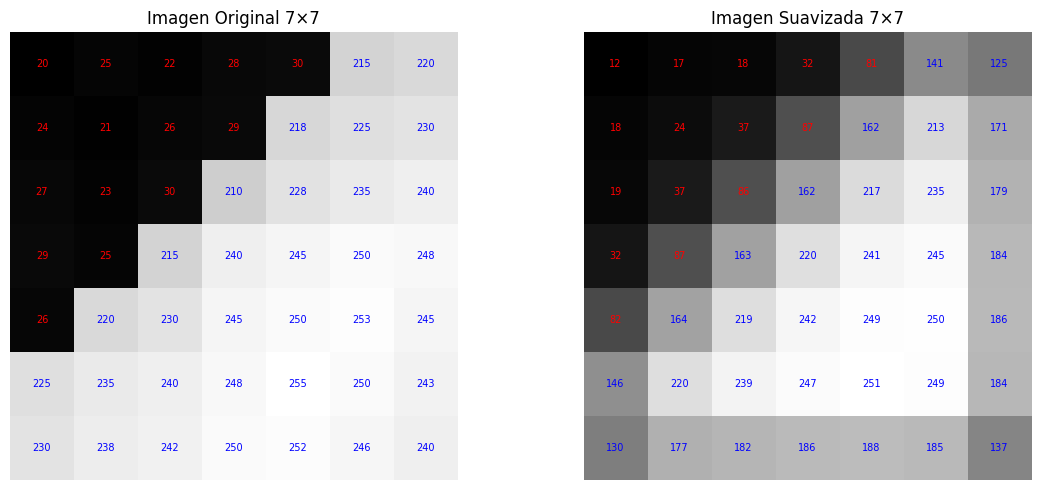

In [6]:
# Aplicar suavizado Gaussiano
S_7x7 = F.conv2d(I_7x7, K_g, padding=1)
S_7x7_np = S_7x7.squeeze().numpy()

print(f"Valor Suavizado S(3,3): {S_7x7[0,0,3,3].item():.2f}")
print(f'\nMatriz Suavizada:')
print(np.round(S_7x7_np, 2))

# Visualización comparativa
figure, axes = pp.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].imshow(I_7x7_np, cmap='gray')
axes[0].set_title('Imagen Original 7×7')
axes[0].axis('off')
for (j, i), label in np.ndenumerate(I_7x7_np):
    axes[0].text(i, j, f'{int(label)}', ha='center', va='center', 
                 color='red' if label < 100 else 'blue', fontsize=7)

axes[1].imshow(S_7x7_np, cmap='gray')
axes[1].set_title('Imagen Suavizada 7×7')
axes[1].axis('off')
for (j, i), label in np.ndenumerate(S_7x7_np):
    axes[1].text(i, j, f'{label:.0f}', ha='center', va='center', 
                 color='red' if label < 100 else 'blue', fontsize=7)

pp.tight_layout()
pp.show()

### Etapa 2: Gradientes (Sobel) - Imagen 7×7

Calculamos los gradientes horizontal y vertical usando los kernels de Sobel, analizando el píxel central $(3,3)$ y sus 8 vecinos.

Magnitud M(3,3): 453.02
Ángulo Theta(3,3): 45.65°

=== Análisis del píxel central (3,3) y sus 8 vecinos ===

Posición        Gx         Gy         Magnitud     Ángulo    
-----------------------------------------------------------------
Arriba-Izq        447.75    448.38      633.66     45.04°
Arriba            463.69    472.81      662.24     45.56°
Arriba-Der        297.44    324.94      440.51     47.53°
Izquierda         471.12    472.00      666.89     45.05°
CENTRO            316.69    323.94      453.02     45.65°
Derecha           130.31    157.69      204.56     50.43°
Abajo-Izq         317.06    310.94      444.08     44.44°
Abajo             149.62    137.88      203.46     42.66°
Abajo-Der          42.25     49.00       64.70     49.23°


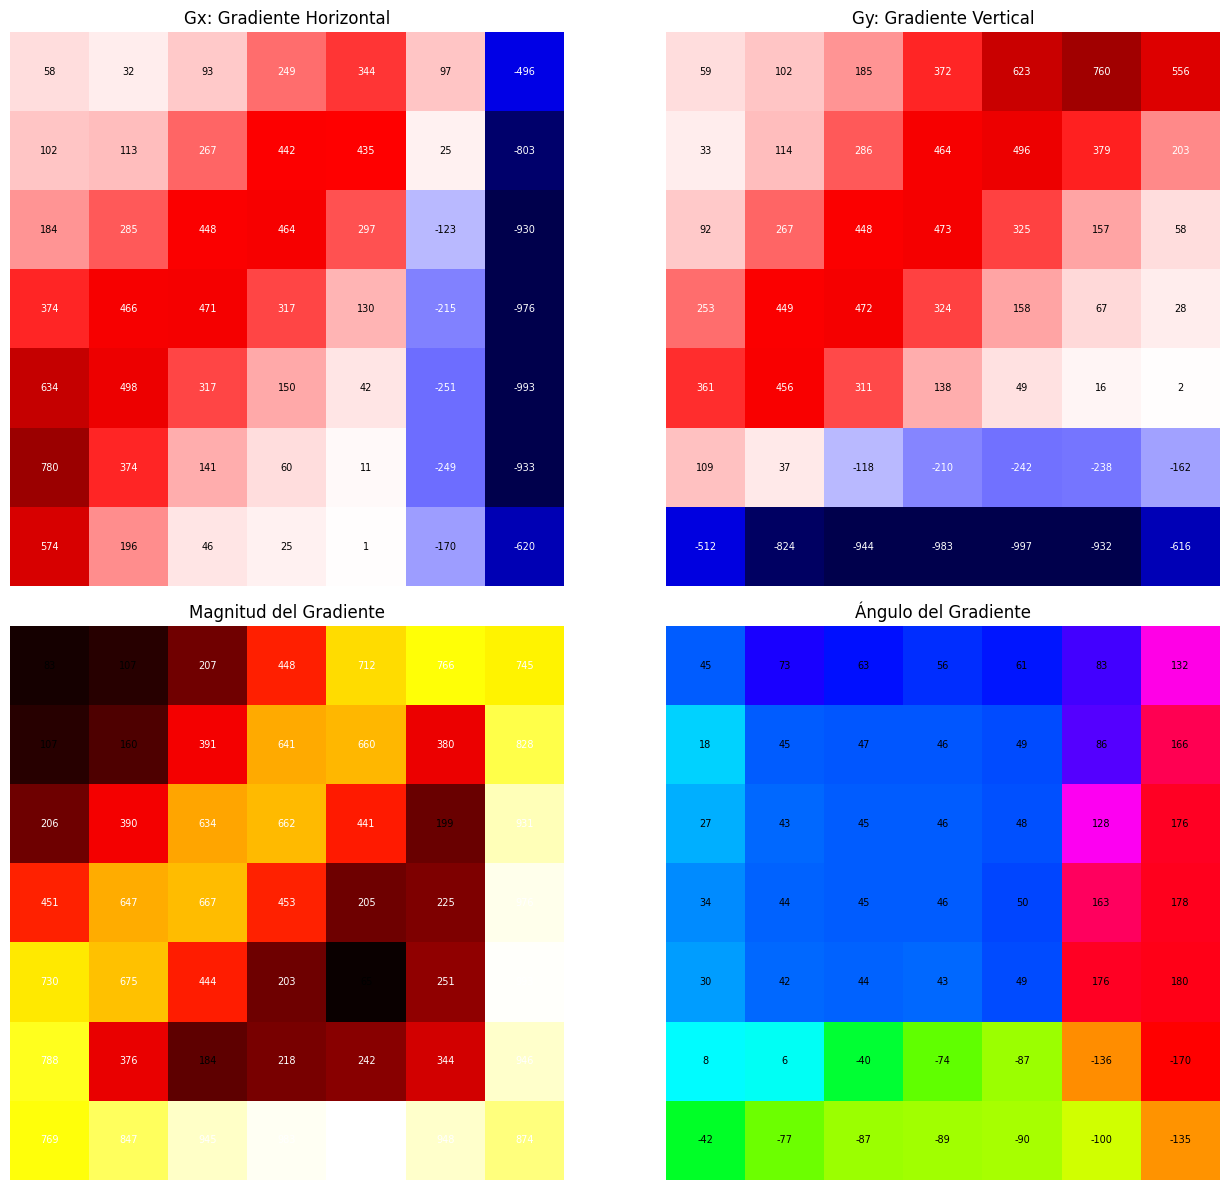

In [7]:
# Calcular gradientes
Gx_7x7 = F.conv2d(S_7x7, K_x, padding=1)
Gy_7x7 = F.conv2d(S_7x7, K_y, padding=1)

M_7x7 = torch.sqrt(Gx_7x7**2 + Gy_7x7**2)
Theta_7x7 = torch.atan2(Gy_7x7, Gx_7x7) * (180 / np.pi)
Theta_7x7_raw = Theta_7x7.clone()
Theta_7x7[Theta_7x7 < 0] += 180

print(f"Magnitud M(3,3): {M_7x7[0,0,3,3].item():.2f}")
print(f"Ángulo Theta(3,3): {Theta_7x7[0,0,3,3].item():.2f}°")

# Extraer el píxel central y sus 8 vecinos
center_y, center_x = 3, 3
print(f"\n=== Análisis del píxel central (3,3) y sus 8 vecinos ===\n")

# Definir las posiciones de los 8 vecinos
neighbors_pos = [
    (center_y-1, center_x-1, "Arriba-Izq"),
    (center_y-1, center_x, "Arriba"),
    (center_y-1, center_x+1, "Arriba-Der"),
    (center_y, center_x-1, "Izquierda"),
    (center_y, center_x, "CENTRO"),
    (center_y, center_x+1, "Derecha"),
    (center_y+1, center_x-1, "Abajo-Izq"),
    (center_y+1, center_x, "Abajo"),
    (center_y+1, center_x+1, "Abajo-Der")
]

print(f"{'Posición':<15} {'Gx':<10} {'Gy':<10} {'Magnitud':<12} {'Ángulo':<10}")
print("-" * 65)
for y, x, name in neighbors_pos:
    gx = Gx_7x7[0,0,y,x].item()
    gy = Gy_7x7[0,0,y,x].item()
    mag = M_7x7[0,0,y,x].item()
    ang = Theta_7x7[0,0,y,x].item()
    print(f"{name:<15} {gx:>8.2f}  {gy:>8.2f}  {mag:>10.2f}  {ang:>8.2f}°")

# Visualización de gradientes
maxim_7x7 = abs(torch.max(torch.max(Gx_7x7), torch.max(Gy_7x7))) + 100

figure, axes = pp.subplots(nrows=2, ncols=2, figsize=(14, 12))

axes[0, 0].imshow(Gx_7x7.squeeze().numpy(), cmap='seismic', vmin=-maxim_7x7, vmax=maxim_7x7)
axes[0, 0].set_title('Gx: Gradiente Horizontal')
axes[0, 0].axis('off')

axes[0, 1].imshow(Gy_7x7.squeeze().numpy(), cmap='seismic', vmin=-maxim_7x7, vmax=maxim_7x7)
axes[0, 1].set_title('Gy: Gradiente Vertical')
axes[0, 1].axis('off')

axes[1, 0].imshow(M_7x7.squeeze().numpy(), cmap='hot')
axes[1, 0].set_title('Magnitud del Gradiente')
axes[1, 0].axis('off')

axes[1, 1].imshow(Theta_7x7_raw.squeeze().numpy(), cmap='hsv')
axes[1, 1].set_title('Ángulo del Gradiente')
axes[1, 1].axis('off')

# Anotar valores en cada subgráfica
matrices = [Gx_7x7.squeeze().numpy(), Gy_7x7.squeeze().numpy(), 
            M_7x7.squeeze().numpy(), Theta_7x7_raw.squeeze().numpy()]
for idx, (ax, matrix) in enumerate(zip(axes.flatten(), matrices)):
    for (j, i), label in np.ndenumerate(matrix):
        color = 'white' if abs(label) > 200 else 'black'
        ax.text(i, j, f'{label:.0f}', ha='center', va='center', 
                color=color, fontsize=7)

pp.tight_layout()
pp.show()

### Etapa 3: Supresión de No Máximos (NMS) - Imagen 7×7

Aplicamos NMS para adelgazar los bordes detectados. Analizaremos cómo cada uno de los 8 vecinos del píxel central es procesado según su dirección de gradiente.

In [9]:
# Definir la función NMS (necesaria para el ejercicio 7x7)
def nms_step(mag, ang):
    """
    Aplica Supresión de No Máximos.
    mag: Tensor de magnitud (Batch, Channel, Height, Width)
    ang: Tensor de ángulo (Batch, Channel, Height, Width)
    """
    B, C, H, W = mag.shape
    res = torch.zeros_like(mag)

    # Quitamos dimensiones de batch/channel para iterar más fácil (suponiendo B=1, C=1)
    m = mag.squeeze()
    a = ang.squeeze()

    # Iteramos sobre los píxeles (excluyendo el borde de 1px para evitar errores de índice)
    for i in range(1, H-1):
        for j in range(1, W-1):
            q = 255.0
            r = 255.0
            angle = a[i,j].item()

            # --- Lógica de Ángulos ---
            # Ángulo 0 (Horizontal)
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                q = m[i, j+1]
                r = m[i, j-1]

            # Ángulo 45 (Diagonal /)
            elif (22.5 <= angle < 67.5):
                q = m[i-1, j+1] # Arriba-Derecha
                r = m[i+1, j-1] # Abajo-Izquierda

            # Ángulo 90 (Vertical)
            elif (67.5 <= angle < 112.5):
                q = m[i+1, j]   # Abajo
                r = m[i-1, j]   # Arriba

            # Ángulo 135 (Diagonal \)
            elif (112.5 <= angle < 157.5):
                q = m[i-1, j-1] # Arriba-Izquierda
                r = m[i+1, j+1] # Abajo-Derecha

            # --- Comparación y Supresión ---
            if (m[i,j] >= q) and (m[i,j] >= r):
                res[0,0,i,j] = m[i,j] # Se mantiene el valor
            else:
                res[0,0,i,j] = 0      # Se suprime

    return res

print("✓ Función nms_step definida correctamente")

✓ Función nms_step definida correctamente


=== Resultado de NMS para el píxel central y sus 8 vecinos ===

Posición        Mag Original    Ángulo       Después NMS     Estado    
---------------------------------------------------------------------------
Arriba-Izq             633.66       45.04°           0.00  SUPRIMIDO 
Arriba                 662.24       45.56°           0.00  SUPRIMIDO 
Arriba-Der             440.51       47.53°           0.00  SUPRIMIDO 
Izquierda              666.89       45.05°           0.00  SUPRIMIDO 
CENTRO                 453.02       45.65°         453.02  CONSERVADO
Derecha                204.56       50.43°         204.56  CONSERVADO
Abajo-Izq              444.08       44.44°           0.00  SUPRIMIDO 
Abajo                  203.46       42.66°           0.00  SUPRIMIDO 
Abajo-Der               64.70       49.23°           0.00  SUPRIMIDO 


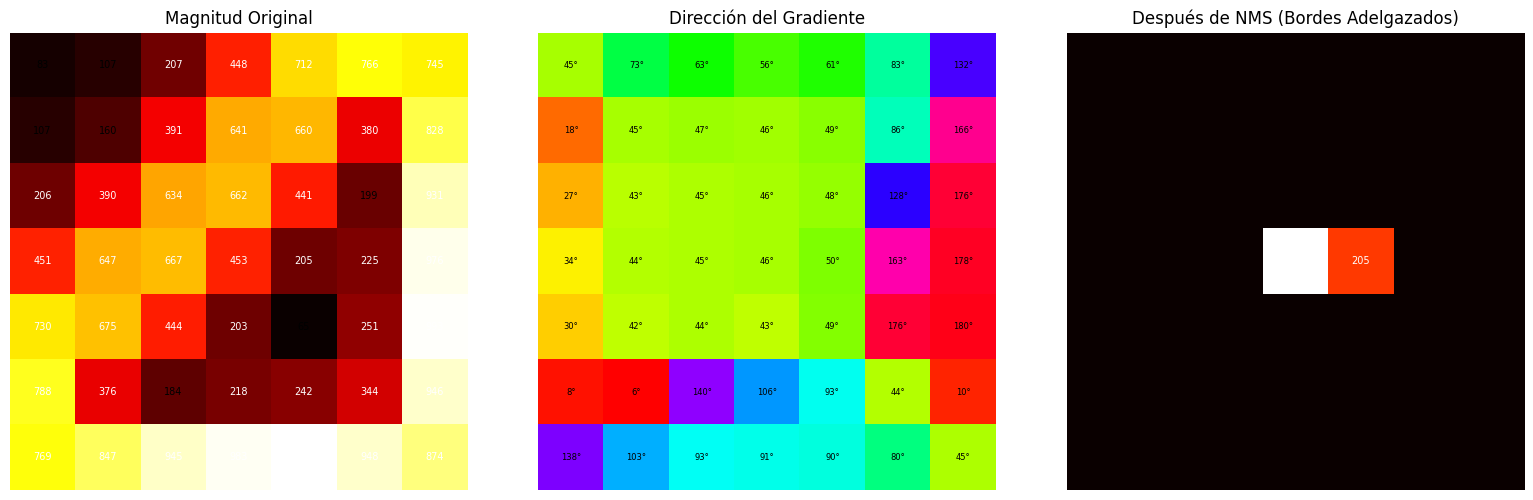

In [10]:
# Aplicar NMS a la imagen 7x7
NMS_7x7 = nms_step(M_7x7, Theta_7x7)
NMS_7x7_np = NMS_7x7.squeeze().numpy()

print("=== Resultado de NMS para el píxel central y sus 8 vecinos ===\n")
print(f"{'Posición':<15} {'Mag Original':<15} {'Ángulo':<12} {'Después NMS':<15} {'Estado':<10}")
print("-" * 75)

for y, x, name in neighbors_pos:
    mag_orig = M_7x7[0,0,y,x].item()
    ang = Theta_7x7[0,0,y,x].item()
    nms_val = NMS_7x7[0,0,y,x].item()
    estado = "SUPRIMIDO" if nms_val == 0 else "CONSERVADO"
    print(f"{name:<15} {mag_orig:>13.2f}  {ang:>10.2f}°  {nms_val:>13.2f}  {estado:<10}")

# Visualización comparativa
figure, axes = pp.subplots(nrows=1, ncols=3, figsize=(16, 5))

# Magnitud original
axes[0].imshow(M_7x7.squeeze().numpy(), cmap='hot')
axes[0].set_title('Magnitud Original')
axes[0].axis('off')
for (j, i), label in np.ndenumerate(M_7x7.squeeze().numpy()):
    axes[0].text(i, j, f'{label:.0f}', ha='center', va='center', 
                 color='white' if label > 200 else 'black', fontsize=7)

# Ángulos cuantizados
axes[1].imshow(Theta_7x7.squeeze().numpy(), cmap='hsv')
axes[1].set_title('Dirección del Gradiente')
axes[1].axis('off')
for (j, i), label in np.ndenumerate(Theta_7x7.squeeze().numpy()):
    axes[1].text(i, j, f'{label:.0f}°', ha='center', va='center', 
                 color='black', fontsize=6)

# Resultado NMS
axes[2].imshow(NMS_7x7_np, cmap='hot')
axes[2].set_title('Después de NMS (Bordes Adelgazados)')
axes[2].axis('off')
for (j, i), label in np.ndenumerate(NMS_7x7_np):
    if label > 0:
        axes[2].text(i, j, f'{label:.0f}', ha='center', va='center', 
                     color='white', fontsize=7)

pp.tight_layout()
pp.show()

### Análisis Detallado de los 8 Vecinos

Veamos en detalle cómo cada vecino del píxel central $(3,3)$ fue procesado durante la NMS:

**Vecindario 3×3 centrado en (3,3):**

$$
\begin{pmatrix}
(2,2) & (2,3) & (2,4) \\
(3,2) & \mathbf{(3,3)} & (3,4) \\
(4,2) & (4,3) & (4,4)
\end{pmatrix}
$$

Para cada píxel, NMS compara su magnitud con los dos vecinos en la dirección del gradiente:

- **Ángulo 0°-22.5° o 157.5°-180° (Horizontal):** Compara con vecinos izquierda/derecha
- **Ángulo 22.5°-67.5° (Diagonal /):** Compara con arriba-derecha/abajo-izquierda
- **Ángulo 67.5°-112.5° (Vertical):** Compara con arriba/abajo
- **Ángulo 112.5°-157.5° (Diagonal \\):** Compara con arriba-izquierda/abajo-derecha

Un píxel se **conserva** si su magnitud es mayor o igual a sus dos vecinos en la dirección del gradiente. De lo contrario, se **suprime** (valor = 0).

### Etapa 4: Histéresis - Imagen 7×7

Finalmente, aplicamos umbrales dobles para clasificar los bordes como fuertes, débiles o ruido.

=== Histéresis con T_low=100, T_high=250 ===

Posición        NMS          Clasificación        Valor Final 
-----------------------------------------------------------------
Arriba-Izq            0.00  Suprimido/Ruido               0
Arriba                0.00  Suprimido/Ruido               0
Arriba-Der            0.00  Suprimido/Ruido               0
Izquierda             0.00  Suprimido/Ruido               0
CENTRO              453.02  Borde Fuerte                255
Derecha             204.56  Borde Débil                 255
Abajo-Izq             0.00  Suprimido/Ruido               0
Abajo                 0.00  Suprimido/Ruido               0
Abajo-Der             0.00  Suprimido/Ruido               0


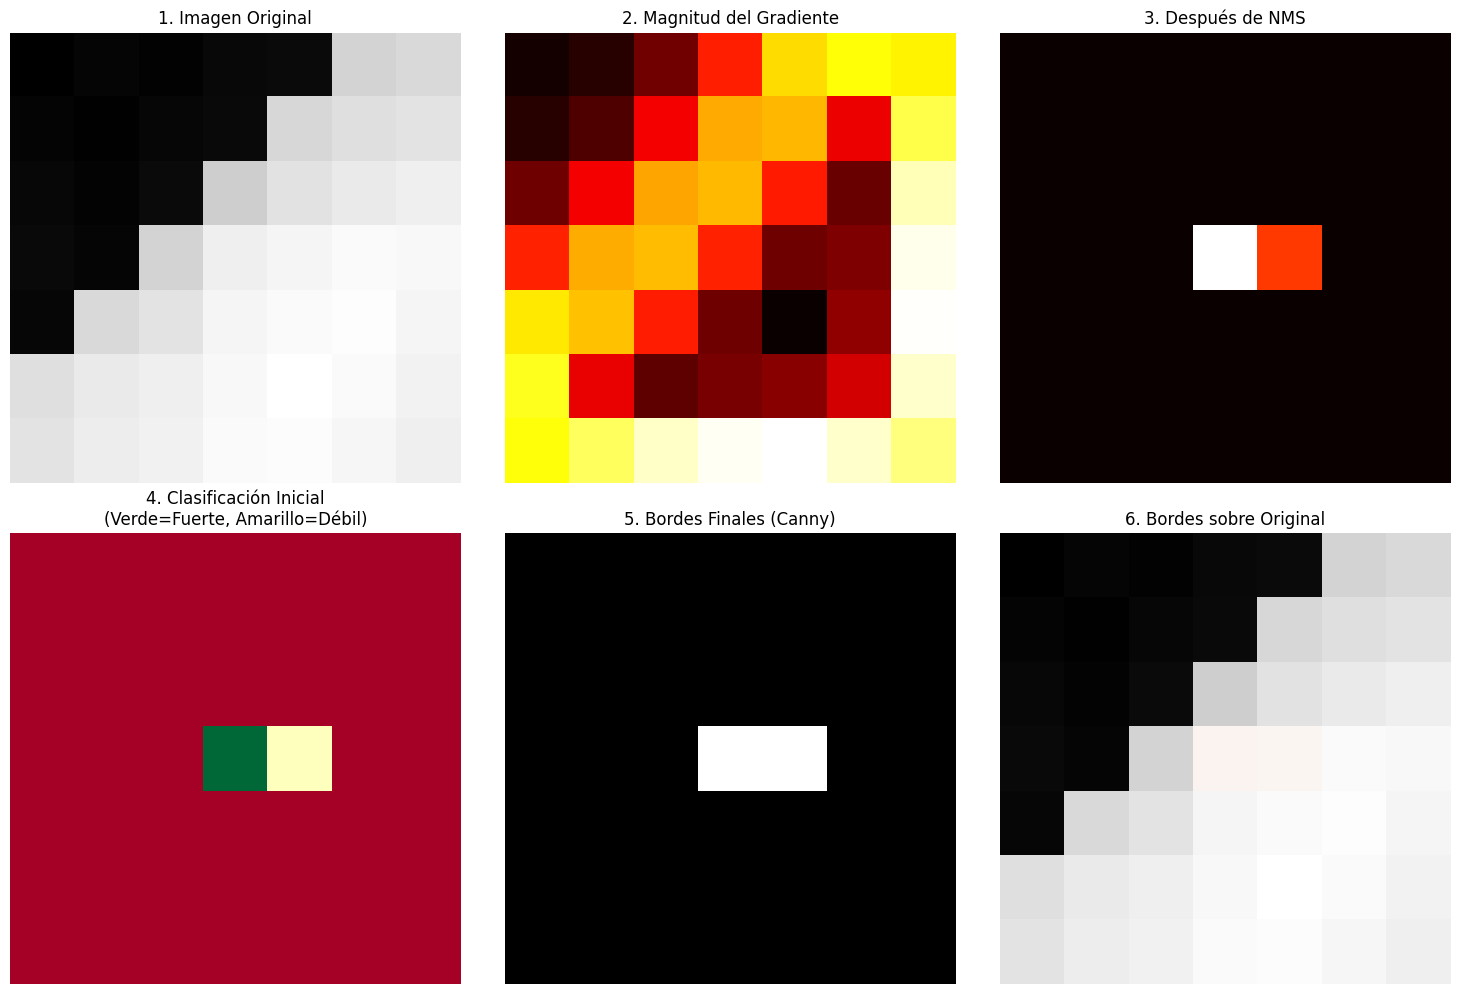


✓ Proceso completo de Canny finalizado para imagen 7×7
✓ Píxeles de borde detectados: 2
✓ Píxeles de borde detectados: 2


In [11]:
def hysteresis(nms_img, T_low, T_high):
    """
    Aplica umbralización por histéresis para clasificar bordes.
    
    Args:
        nms_img: Imagen después de NMS (Batch, Channel, Height, Width)
        T_low: Umbral bajo
        T_high: Umbral alto
    
    Returns:
        Imagen binaria con bordes finales
    """
    B, C, H, W = nms_img.shape
    result = torch.zeros_like(nms_img)
    
    # Clasificación inicial
    strong = (nms_img >= T_high)
    weak = (nms_img >= T_low) & (nms_img < T_high)
    
    result[strong] = 255.0  # Bordes fuertes
    result[weak] = 50.0     # Bordes débiles (candidatos)
    
    # Conectividad: propagar bordes fuertes a débiles conectados
    nms_np = nms_img.squeeze().numpy()
    res_np = result.squeeze().numpy()
    
    changed = True
    iterations = 0
    max_iterations = 10
    
    while changed and iterations < max_iterations:
        changed = False
        iterations += 1
        
        for i in range(1, H-1):
            for j in range(1, W-1):
                if res_np[i,j] == 50:  # Si es borde débil
                    # Verificar si tiene algún vecino fuerte (8-conectividad)
                    neighbors = [
                        res_np[i-1, j-1], res_np[i-1, j], res_np[i-1, j+1],
                        res_np[i, j-1],                    res_np[i, j+1],
                        res_np[i+1, j-1], res_np[i+1, j], res_np[i+1, j+1]
                    ]
                    
                    if 255 in neighbors:
                        res_np[i,j] = 255  # Promover a borde fuerte
                        changed = True
    
    # Suprimir bordes débiles no conectados
    res_np[res_np == 50] = 0
    
    result = torch.from_numpy(res_np).unsqueeze(0).unsqueeze(0).float()
    return result

# Aplicar histéresis
T_low = 100
T_high = 250

Edges_7x7 = hysteresis(NMS_7x7, T_low, T_high)
Edges_7x7_np = Edges_7x7.squeeze().numpy()

print(f"=== Histéresis con T_low={T_low}, T_high={T_high} ===\n")
print(f"{'Posición':<15} {'NMS':<12} {'Clasificación':<20} {'Valor Final':<12}")
print("-" * 65)

for y, x, name in neighbors_pos:
    nms_val = NMS_7x7[0,0,y,x].item()
    final_val = Edges_7x7[0,0,y,x].item()
    
    if nms_val >= T_high:
        clasificacion = "Borde Fuerte"
    elif nms_val >= T_low:
        clasificacion = "Borde Débil"
    else:
        clasificacion = "Suprimido/Ruido"
    
    print(f"{name:<15} {nms_val:>10.2f}  {clasificacion:<20} {final_val:>10.0f}")

# Visualización final comparativa
figure, axes = pp.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Fila 1: Proceso completo
axes[0, 0].imshow(I_7x7_np, cmap='gray')
axes[0, 0].set_title('1. Imagen Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(M_7x7.squeeze().numpy(), cmap='hot')
axes[0, 1].set_title('2. Magnitud del Gradiente')
axes[0, 1].axis('off')

axes[0, 2].imshow(NMS_7x7_np, cmap='hot')
axes[0, 2].set_title('3. Después de NMS')
axes[0, 2].axis('off')

# Fila 2: Clasificación por histéresis
strong_mask = (NMS_7x7_np >= T_high)
weak_mask = (NMS_7x7_np >= T_low) & (NMS_7x7_np < T_high)

classification = np.zeros_like(NMS_7x7_np)
classification[strong_mask] = 2  # Fuerte
classification[weak_mask] = 1    # Débil

axes[1, 0].imshow(classification, cmap='RdYlGn', vmin=0, vmax=2)
axes[1, 0].set_title('4. Clasificación Inicial\n(Verde=Fuerte, Amarillo=Débil)')
axes[1, 0].axis('off')

axes[1, 1].imshow(Edges_7x7_np, cmap='gray')
axes[1, 1].set_title('5. Bordes Finales (Canny)')
axes[1, 1].axis('off')

# Superposición
overlay = I_7x7_np.copy()
axes[1, 2].imshow(overlay, cmap='gray')
edges_colored = np.ma.masked_where(Edges_7x7_np == 0, Edges_7x7_np)
axes[1, 2].imshow(edges_colored, cmap='Reds', alpha=0.7)
axes[1, 2].set_title('6. Bordes sobre Original')
axes[1, 2].axis('off')

pp.tight_layout()
pp.show()

print(f"\n✓ Proceso completo de Canny finalizado para imagen 7×7")
print(f"✓ Píxeles de borde detectados: {int(torch.sum(Edges_7x7 > 0).item())}")

### Resumen del Ejercicio 7×7

En este ejercicio extendido hemos:

1. **Creado una imagen 7×7** con un patrón de borde diagonal más complejo
2. **Analizado el píxel central $(3,3)$ y sus 8 vecinos** en cada etapa:
   - Suavizado Gaussiano
   - Cálculo de gradientes (Sobel)
   - Supresión de No Máximos (NMS)
   - Umbralización por Histéresis

3. **Visualizado cómo cada vecino es procesado** según su magnitud y dirección de gradiente

4. **Aplicado la conectividad de 8 vecinos** en la fase de histéresis para propagar bordes fuertes a débiles conectados

Este análisis completo demuestra cómo el algoritmo de Canny procesa no solo un píxel, sino todo su vecindario, para determinar qué constituye un borde verdadero versus ruido.